# Models, Simulations, Tables and Plots

This script computes the simulations and associated moments of several version of the model, with and without self-fulfilling shocks, with short and long debt, and with the floating rate bond.

In [30]:
import Pkg; Pkg.activate(joinpath(@__DIR__, "..")); Pkg.instantiate()

using Revise
using LTBonds
using Random 
using PrettyTables
using Plots
using LaTeXStrings

  Activating project at `~/Github/floating_rate`


In [2]:
SAVE_MOMENTS = false # set to true to save the moments to file. 
SAVE_FIGS = false 

false

# Models

In [3]:
benchmark_parameters =  let
    R = 1.01
    β = 0.9540232420
    pref = Preferences(β = β, u = make_CRRA(ra = 2))
    y = discretize(YProcess(n = 50, ρ = 0.948503, std = 0.027092, μ = 0.0, span = 3.0, tails = false))
    m = MTruncatedNormal(; std = 0.01, span = 2.0, quadN = 100)
    penalty = DefCosts(pen1 = -0.1881927550, pen2 = 0.2455843389, quadratic = true, reentry = 0.0385)
    η=0.1

    (R = R, pref = pref, y = y, m = m, penalty = penalty, η = η)
end;

In [4]:
models = let
    R, pref, y, m, penalty, η = benchmark_parameters

    bondFR = FloatingRateBond(;n = 350, min = 0.0, max = 1.5, λ = 0.05, κbar = 0.06) 
    bondFRlowκ = FloatingRateBond(;n = 350, min = 0.0, max = 1.5, λ = 0.05, κbar = 0.015) 
    bondLT = Bond(n = 350, min = 0.0, max = 1.5, κ = R - 1, λ = 0.05)  
    bondST = Bond(n = 350, min = 0.0, max = 1.5, κ = R - 1, λ = 1.0)  
    
    fr = generate_workspace(
        CKLTBondModel(
            y = y,
            m = m, 
            preferences = pref, 
            bond = bondFR, 
            def_costs = penalty, 
            R = R,
            η = η
        )
    )

    frlowκ = generate_workspace(
        CKLTBondModel(
            y = y,
            m = m, 
            preferences = pref, 
            bond = bondFRlowκ, 
            def_costs = penalty, 
            R = R,
            η = η
        )
    )   

    egLT = generate_workspace(
        LTBondModel(
            y = y,
            m = m, 
            preferences = pref, 
            bond = bondLT, 
            def_costs = penalty, 
            R = R,
        )
    )

    ckLT = generate_workspace(
        CKLTBondModel(
            y = y,
            m = m, 
            preferences = pref, 
            bond = bondLT, 
            def_costs = penalty, 
            R = R,
            η = η
        )
    )

    egST = generate_workspace(
        LTBondModel(
            y = y,
            m = m, 
            preferences = pref, 
            bond = bondST, 
            def_costs = penalty, 
            R = R,
        )
    )

    ckST = generate_workspace(
        CKLTBondModel(
            y = y,
            m = m, 
            preferences = pref, 
            bond = bondST, 
            def_costs = penalty, 
            R = R,
            η = η
        )
    )


    (; fr, frlowκ, egLT, ckLT, egST, ckST) 
end;

In [5]:
@time for m ∈ models
    @time solve!(m; print_every = 200, max_iters = 5_000, err = 1e-4)
end

1: (v = 1.4304966712931169, κ = 0.04999999999999999, q = 0.6091402083520817, vD = 0.5336647908767098)
201: (v = 0.009426288264176463, κ = 0.0021488574675934125, q = 0.016999073119353558, vD = 8.440532472420159e-5)
311: (v = 2.2279434951144594e-5, κ = 1.3576516539215433e-5, q = 1.3469914095565194e-5, vD = 1.9225872271988464e-6)
Converged.
131.081518 seconds (22.85 M allocations: 1.352 GiB, 0.33% gc time, 11.50% compilation time)
1: (v = 1.4304966712931169, κ = 0.0049999999999999906, q = 0.6091402083520817, vD = 0.5336647908767098)
201: (v = 0.0004991181069833317, κ = 0.00024817102644680844, q = 0.0016605596415601998, vD = 0.00015718183862034607)
302: (v = 2.5514270880933054e-5, κ = 7.648022724016101e-6, q = 9.885058430436633e-5, vD = 1.0485037464036395e-5)
Converged.
119.914182 seconds (33.00 k allocations: 3.041 MiB)
1: (v = 1.503244195357336, q = 0.580987691900618, vD = 0.5336647908767098)
201: (v = 0.00017933770320155418, q = 0.0008063805687396064, vD = 0.00011157254404636774)
255: (

# Simulations

In [6]:
big_T = 20_000 
big_N = 1_000
rng = Random.seed!(1234)

TaskLocalRNG()

In [7]:
computed_moments = map(models) do (m) 
    shocks, paths = create_shocks_paths(models.fr, big_T, big_N; rng);
    simulation!(paths, shocks, m; n = big_T, trim = 1000, trim_def = 20)
    moments(paths, m)
end;

In [8]:
pretty_table(
    collect(map(m -> pairs(m), computed_moments)),
    row_names = collect(keys(computed_moments)), 
    backend = Val(:html),
    formatters = ( ft_printf("%5.3f", [7, 8]), ft_printf("%5.3f"))
)

,mean_bp_y,mean_mv_y,mean_spread,std_spread,mean_κ,max_spread,std_κ,max_κ,std_c_y,cor_tb_y,cor_r_y,cor_r_b_y,cor_r_tb,def_rate,run_share
fr,0.816,0.816,0.003,0.005,0.011,1.062,0.001,0.060,1.134,-0.223,-0.371,-0.189,0.713,0.003,0.087
frlowκ,0.871,0.776,0.038,0.029,0.011,0.540,0.002,0.015,1.118,-0.303,-0.435,0.035,0.565,0.033,0.003
egLT,0.936,0.723,0.080,0.044,0.010,0.635,0.000,0.010,1.104,-0.389,-0.647,-0.027,0.728,0.067,0.000
ckLT,0.936,0.723,0.080,0.044,0.010,0.636,0.000,0.010,1.105,-0.390,-0.648,-0.028,0.729,0.067,0.003
egST,0.821,0.820,0.003,0.004,0.010,0.037,0.000,0.010,1.133,-0.223,-0.445,-0.220,0.852,0.003,0.000
ckST,0.375,0.375,0.002,0.003,0.010,0.034,0.000,0.010,1.054,-0.187,-0.665,-0.493,0.686,0.002,1.000


In [9]:
SAVE_MOMENTS && open(joinpath(@__DIR__,"..","output","moments.txt"), "w") do f
    pretty_table(
        collect(map(m -> pairs(m), computed_moments)),
        row_names = collect(keys(computed_moments)), 
        backend = Val(:html),
        formatters = ft_printf("%5.3f")
    )
end

false

## Plots

In [20]:
#set linewidth for plots:
lw = 2
ms = 3
msdiamond = 5
default(size = (600, 400), xtickfontsize = 12, ytickfontsize = 12, yguidefontsize = 14, xguidefontsize = 14)

In [21]:
###Value at zero debt plots###
midY = length(get_y_grid(models.fr)) ÷ 2
ygrid = get_y_grid(models.fr);

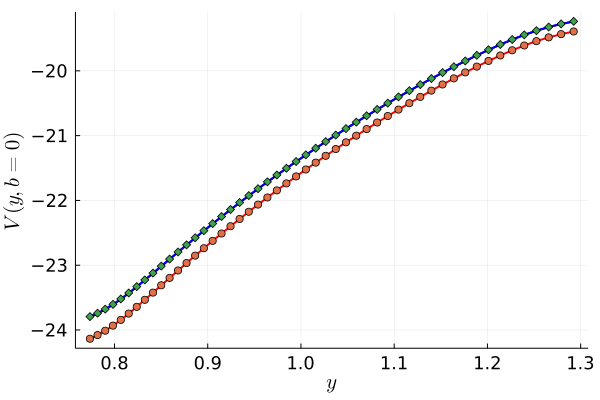

In [22]:
f1 = plot(ygrid, get_v(models.fr)[1,:,midY], line = (lw, :black), legend = false, xlabel = (L"$y$"),
        ylabel = (L"$V(y,b=0)$"))
plot!(f1, ygrid, get_v(models.ckST)[1,:] , line = (lw, :red), markershape = :circle)
plot!(f1, ygrid, get_v(models.egST)[1,:] , line = (lw, :blue), markershape = :diamond)
SAVE_FIGS && savefig(f1, joinpath(@__DIR__, "..", "output", "V0ST.pdf"))
f1

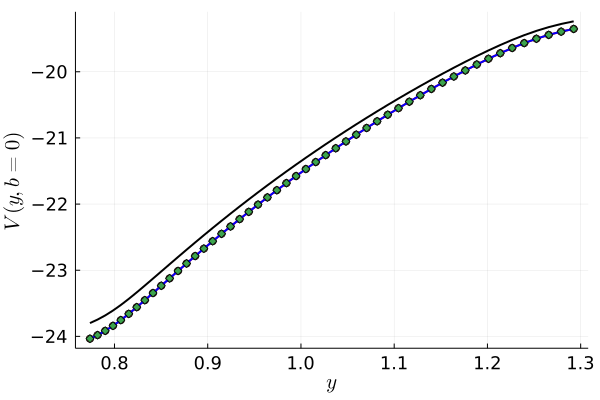

In [23]:
f2 = plot(ygrid, get_v(models.fr)[1,:,midY], line = (lw, :black), legend=false,
        xlabel = (L"$y$"), ylabel = (L"$V(y,b=0)$"))
plot!(f2, ygrid, get_v(models.ckLT)[1,:] , line = (lw, :red), markershape = :circle)
plot!(f2, ygrid, get_v(models.egLT)[1,:] , line = (lw, :blue), markershape = :diamond)
SAVE_FIGS && savefig(f2, joinpath(@__DIR__, "..", "output", "V0LT.pdf"))
f2

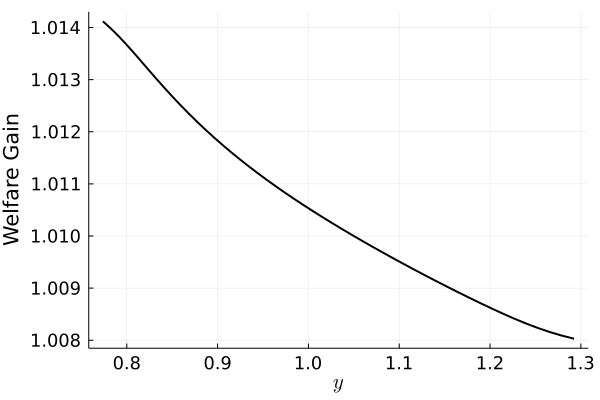

In [24]:
welfareST = [
    inv_u.(Ref(get_u(models.fr)), get_v(models.fr)[1, i, 1]) ./ 
    inv_u.(Ref(get_u(models.ckST)), get_v(models.ckST)[1,i]) for i = 1:length(-get_v(models.fr)[1, :, 1])];

f3 = plot(ygrid, welfareST, line=(lw, :black), legend = false, xlabel = L"$y$",
        ylabel = "Welfare Gain")
SAVE_FIGS && savefig(f3, joinpath(@__DIR__, "..", "output", "WST.pdf"))
f3

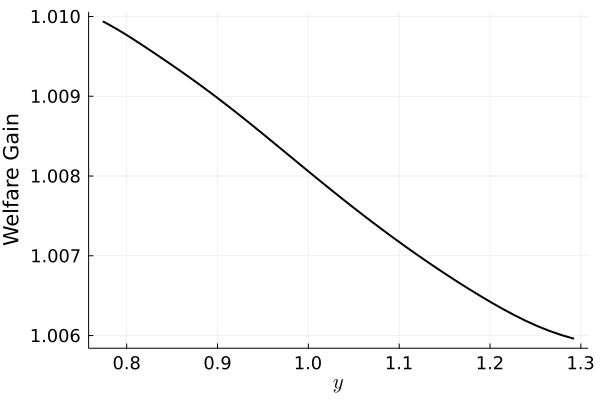

In [25]:
welfareLT = [
    inv_u.(Ref(get_u(models.fr)), get_v(models.fr)[1, i, 1]) ./ 
    inv_u.(Ref(get_u(models.ckLT)), get_v(models.ckLT)[1,i]) for i = 1:length(-get_v(models.fr)[1, :, 1])]

f4 = plot(ygrid, welfareLT, line = (lw, :black), legend = false, xlabel = L"$y$",
    ylabel = "Welfare Gain")
SAVE_FIGS && savefig(f4, joinpath(@__DIR__, "..", "output", "WLT.pdf"))
f4

### Pareto Frontiers

In [26]:
_get_frontier_y_state(::AbstractFixedRateBond, yi, lag_y) = (yi, )
_get_frontier_y_state(::AbstractFloatingRateBond, yi, lag_y) = (yi, lag_y)
_get_frontier_κ(bond::AbstractFixedRateBond, _, _, _) = get_κ(bond)
_get_frontier_κ(::AbstractFloatingRateBond, m, bi, lag_y) = m.current.κ[bi, lag_y]
_get_frontier_mv(bond::AbstractFixedRateBond, q, b, _) = find_bond_return(bond; q) * b
_get_frontier_mv(bond::AbstractFloatingRateBond, q, b, κ) = find_bond_return(bond; q, κ) * b

get_frontier(m, yi; kwargs...) = get_frontier(get_bond(m), m, yi; kwargs...)

function get_frontier(bond, m::LTBonds.WorkSpace, yi; lag_y = midY)
    bgrid = get_b_grid(m)
    λ = get_λ(bond)
    mv = []
    v = []
    y_state = _get_frontier_y_state(bond, yi, lag_y)
    for bi = 1:length(bgrid)
        default = m.policies.d[bi, y_state...] == m.model.m.m_min
        biprime = get_b_pol(m)[bi, y_state...][end, 1].idx
        q = get_q(m)[biprime, yi]
        κ = _get_frontier_κ(bond, m, bi, lag_y)
        b = get_b_grid(m)[bi]
        push!(mv, (1 - default) * _get_frontier_mv(bond, q, b, κ))
        push!(v, (1 - default) * get_v(m)[bi, y_state...] + default * get_vD(m)[yi])
    end
    return v, mv
end
;

In [27]:
markerevery(series; n = 1) = collect(view(series, 1:n:length(series)))

markerevery (generic function with 1 method)

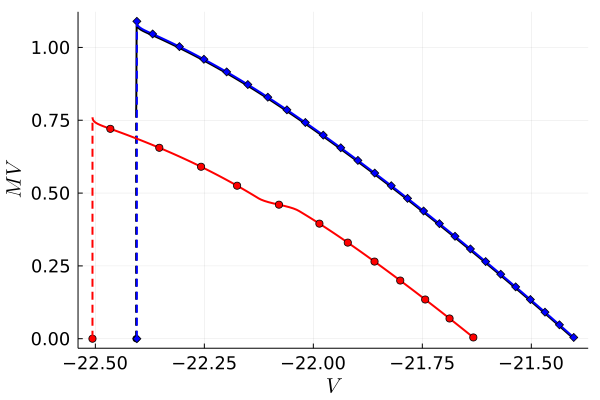

In [28]:
let 
    m = models.fr
    vD = get_vD(m)[midY]
    frontier = get_frontier(m, midY)
    xx = [x  for x in zip(frontier[1], frontier[2]) if x[1] > vD && x[2] > 0]

    f = plot([x[1] for x in xx], [x[2] for x in xx], 
        line=(lw, :black), legend=false, xlabel=(L"$V$"), ylabel=(L"MV")
    )
    plot!(f, [vD], [0], marker = 4, markercolor=:black)
    plot!(f, [vD, xx[end][1]], [0, xx[end][2]], ls = :dash,line=(lw, :black))

    m = models.egST
    vD = get_vD(m)[midY]
    frontier = get_frontier(m, midY)
    xx = [x  for x in zip(frontier[1], frontier[2]) if x[1] > vD && x[2] > 0]
    plot!(f, [x[1] for x in xx], [x[2] for x in xx], 
        line=(lw, :blue))
    xx_f = markerevery(xx; n = 10)
    scatter!(f, [x[1] for x in xx_f], [x[2] for x in xx_f], 
        markershape=:diamond,markercolor=:blue)
    plot!(f, [vD], [0], markershape=:diamond, marker = 4,markercolor=:blue)
    plot!(f, [vD, xx[end][1]], [0, xx[end][2]], ls = :dash,line=(lw, :blue))

    m = models.ckST
    vD = get_vD(m)[midY]
    frontier = get_frontier(m, midY)
    xx = [x  for x in zip(frontier[1], frontier[2]) if x[1] > vD && x[2] > 0]
    plot!(f, [x[1] for x in xx], [x[2] for x in xx], 
        line=(lw, :red))
    xx_f = markerevery(xx; n = 15)
    scatter!(f, [x[1] for x in xx_f], [x[2] for x in xx_f], 
        markershape=:circle,markercolor=:red)
    plot!(f, [vD], [0], markershape=:circle, marker = 4,markercolor=:red)
    plot!(f, [vD, xx[end][1]], [0, xx[end][2]], ls = :dash,line=(lw, :red))

    SAVE_FIGS && savefig(f, joinpath(@__DIR__,"..","output","FrontierST.pdf"))
    f
end 

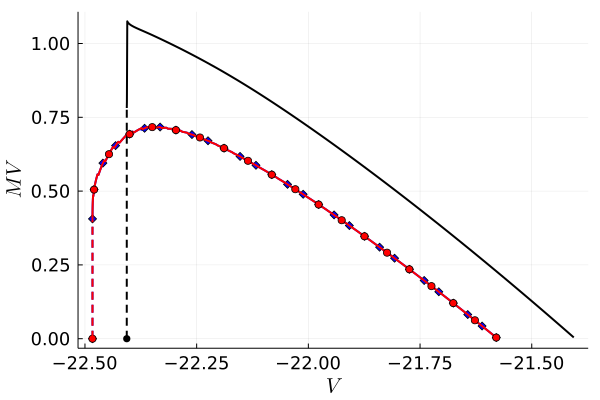

In [29]:
let 
    m = models.fr
    vD = get_vD(m)[midY]
    frontier = get_frontier(m, midY)
    xx = [x  for x in zip(frontier[1], frontier[2]) if x[1] > vD && x[2] > 0]

    f = plot([x[1] for x in xx], [x[2] for x in xx], 
        line=(lw, :black), legend=false, xlabel=(L"$V$"), ylabel=(L"MV")
    )
    plot!(f, [vD], [0], marker = 4, markercolor=:black)
    plot!(f, [vD, xx[end][1]], [0, xx[end][2]], ls = :dash,line=(lw, :black))

    m = models.egLT
    vD = get_vD(m)[midY]
    frontier = get_frontier(m, midY)
    xx = [x  for x in zip(frontier[1], frontier[2]) if x[1] > vD && x[2] > 0]
    plot!(f, [x[1] for x in xx], [x[2] for x in xx], 
        line=(lw, :blue))
    xx_f = markerevery(xx; n = 10)
    scatter!(f, [x[1] for x in xx_f], [x[2] for x in xx_f], 
        markershape=:diamond,markercolor=:blue)
    plot!(f, [vD], [0], markershape=:diamond, marker = 4,markercolor=:blue)
    plot!(f, [vD, xx[end][1]], [0, xx[end][2]], ls = :dash,line=(lw, :blue))

    m = models.ckLT
    vD = get_vD(m)[midY]
    frontier = get_frontier(m, midY)
    xx = [x  for x in zip(frontier[1], frontier[2]) if x[1] > vD && x[2] > 0]
    plot!(f, [x[1] for x in xx], [x[2] for x in xx], 
        line=(lw, :red))
    xx_f = markerevery(xx; n = 15)
    scatter!(f, [x[1] for x in xx_f], [x[2] for x in xx_f], 
        markershape=:circle,markercolor=:red)
    plot!(f, [vD], [0], markershape=:circle, marker = 4,markercolor=:red)
    plot!(f, [vD, xx[end][1]], [0, xx[end][2]], ls = :dash,line=(lw, :red))

    SAVE_FIGS && savefig(f, joinpath(@__DIR__,"..","output","FrontierLT.pdf"))
    f
end 